In [1]:
import json
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW, AutoModelForQuestionAnswering, AutoTokenizer
import os
import re
import string
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
import import_ipynb
import extract_transform_evaluate_ds as docstrideFn
from torch.optim.lr_scheduler import ExponentialLR

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def train_model(self, dataloader, optimizer, scheduler):
    self.train()
    accuracy_arr, loss_arr = [], []
    for batch in tqdm(dataloader, desc='Training Started!'):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(self.device)
        attention_mask = batch['attention_mask'].to(self.device)
        start_pos = batch['start_positions'].to(self.device)
        end_pos = batch['end_positions'].to(self.device)
        start_res, end_res = self(input_ids=input_ids, attention_mask=attention_mask)
        loss = self.find_focal_loss(start_res, end_res, start_pos, end_pos)
        loss_arr.append(loss.item())
        loss.backward()
        optimizer.step()

        start_pred = torch.argmax(start_res, dim=1)
        end_pred = torch.argmax(end_res, dim=1)

        accuracy_arr.append(((start_pred == start_pos).sum()/len(start_pred)).item())
        accuracy_arr.append(((end_pred == end_pos).sum()/len(end_pred)).item())
    scheduler.step()
    return sum(accuracy_arr)/len(accuracy_arr), sum(loss_arr)/len(loss_arr)

def plot_metrics(epochs, train_losses, train_accuracies, wer_scores, f1_scores):
    metrics = {
        'Training Loss': train_losses,
        'Training Accuracy': train_accuracies,
        'Word Error Rate (WER)': wer_scores,
        'F1 Score': f1_scores
    }
    colors = ['blue','green','red','brown']
    plt.figure(figsize=(12, 8))
    
    # Loop over metrics dictionary to create subplots
    for i, (title, values) in enumerate(metrics.items(), start=1):
        plt.subplot(2, 2, i)
        plt.plot(epochs, values, marker='o', linestyle='-', color=colors[i-1])
        plt.title(title)
        plt.xlabel('Epoch')
        plt.ylabel(title.split()[1])
    
    plt.tight_layout()
    plt.show()

Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/home/lmadipa/.conda/envs/pytorch_env/lib/python3.11

Epoch - 1


Training Started!: 100%|██████████| 2320/2320 [06:14<00:00,  6.20it/s]


Train Accuracy: 0.4234817580159368 and Train Loss: 2.02672696820107


Evaluating Model!: 100%|██████████| 15875/15875 [01:20<00:00, 197.04it/s]


F1 Score: 0.602721078443557 and WER Score: 1.531200089143112
Epoch - 2


Training Started!: 100%|██████████| 2320/2320 [06:15<00:00,  6.18it/s]


Train Accuracy: 0.6111761083890652 and Train Loss: 1.1115736326138521


Evaluating Model!: 100%|██████████| 15875/15875 [01:20<00:00, 197.10it/s]


F1 Score: 0.6340485976191624 and WER Score: 1.1949634141811833
Epoch - 3


Training Started!: 100%|██████████| 2320/2320 [06:15<00:00,  6.18it/s]


Train Accuracy: 0.7028055726711092 and Train Loss: 0.7491826500872086


Evaluating Model!: 100%|██████████| 15875/15875 [01:20<00:00, 197.28it/s]


F1 Score: 0.6449198695958895 and WER Score: 1.0660401886862534
Epoch - 4


Training Started!: 100%|██████████| 2320/2320 [06:15<00:00,  6.18it/s]


Train Accuracy: 0.7732142857436476 and Train Loss: 0.5108200301544676


Evaluating Model!: 100%|██████████| 15875/15875 [01:20<00:00, 197.44it/s]


F1 Score: 0.637107158705274 and WER Score: 1.151357575307358
Epoch - 5


Training Started!: 100%|██████████| 2320/2320 [06:15<00:00,  6.18it/s]


Train Accuracy: 0.8253117303139177 and Train Loss: 0.3589794442571443


Evaluating Model!: 100%|██████████| 15875/15875 [01:20<00:00, 197.82it/s]


F1 Score: 0.6415184743678614 and WER Score: 1.1564090183114808
Epoch - 6


Training Started!: 100%|██████████| 2320/2320 [06:15<00:00,  6.18it/s]


Train Accuracy: 0.8631561730442376 and Train Loss: 0.25983750576410314


Evaluating Model!: 100%|██████████| 15875/15875 [01:20<00:00, 197.85it/s]


F1 Score: 0.6394459630226784 and WER Score: 1.1869033911525462


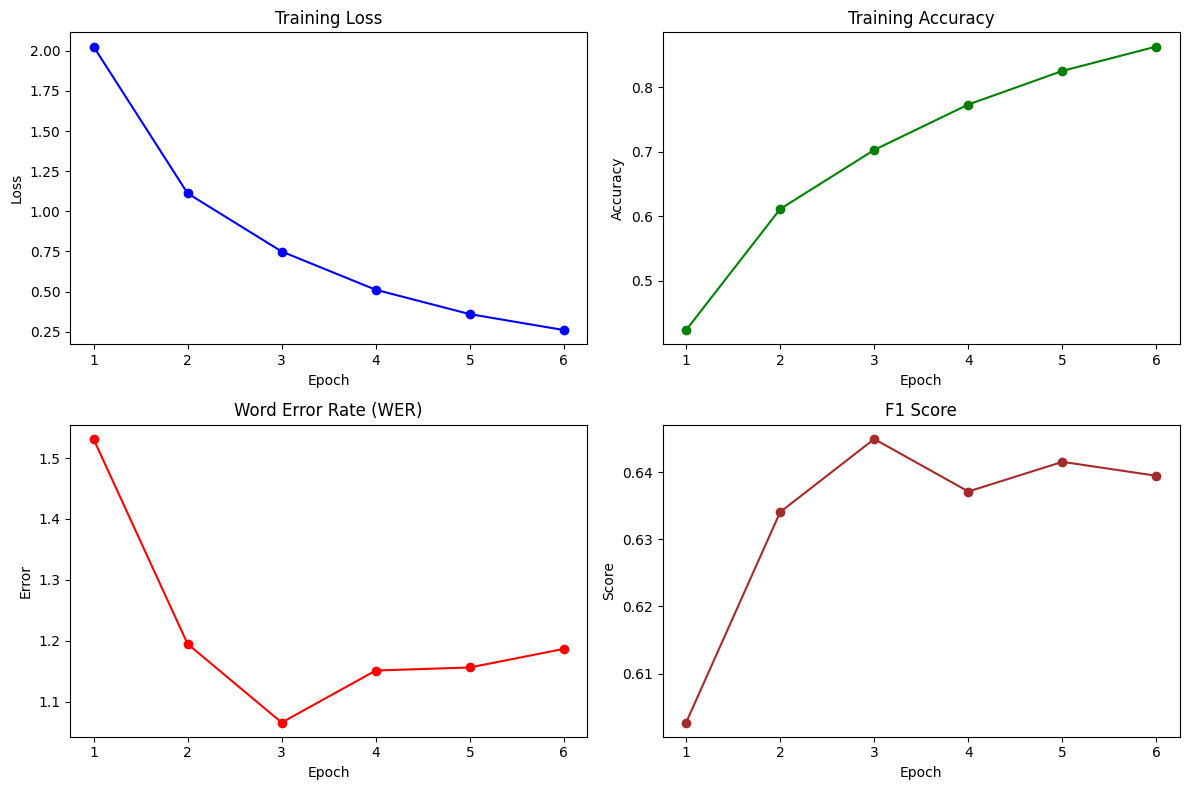

In [2]:
train_data = '../spoken_train-v1.1.json'
test_data = '../spoken_test-v1.1.json'
MODEL_PATH = "distilbert-base-uncased"
MODEL_SAVE_PATH = "qa_scheduler_model"

tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)

train_encodings = docstrideFn.collect_and_find_positions(train_data, tokenizer, 512)
test_encodings = docstrideFn.collect_and_find_positions(test_data, tokenizer, 512)

train_set = docstrideFn.SpokenSquad(train_encodings)
test_set = docstrideFn.SpokenSquad(test_encodings)
train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
test_loader = DataLoader(test_set, batch_size=1)

distilbert_base_uncased_model = AutoModelForQuestionAnswering.from_pretrained(MODEL_PATH)
qa_model = docstrideFn.QAModel(distilbert_base_uncased_model, device)
optimizer = AdamW(qa_model.parameters(), lr=2e-5, weight_decay=0.02)

wer_scores, accuracies, losses, f1_scores  = [], [], [], []

epoch = 0
scheduler = ExponentialLR(optimizer, gamma=0.9)
if not os.path.exists(MODEL_SAVE_PATH):
    os.makedirs(MODEL_SAVE_PATH)

while epoch < 6:
    print(f'Epoch - {epoch + 1}')
    
    accuracy, loss = train_model(qa_model, train_loader, optimizer, scheduler)
    accuracies.append(accuracy)
    losses.append(loss)
    print(f"Train Accuracy: {accuracy} and Train Loss: {loss}")

    avg_f1_score, wer_score = qa_model.evaluate_model(test_loader, tokenizer)
    f1_scores.append(avg_f1_score)
    wer_scores.append(wer_score)
    print(f"F1 Score: {avg_f1_score} and WER Score: {wer_score}")

    epoch += 1

torch.save(qa_model.state_dict(), os.path.join(MODEL_SAVE_PATH, 'model_weights.pt'))
tokenizer.save_pretrained(MODEL_SAVE_PATH)

plot_metrics(range(1, 7), losses, accuracies, wer_scores, f1_scores) 